In [1]:
from modules.loader.DataLoader import DataLoader
from modules.processor.DataProcessor import DataProcessor
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold
from sksurv.ensemble import RandomSurvivalForest
from sksurv.util import Surv
from sksurv.metrics import concordance_index_censored
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_loader = DataLoader()
df_raw = data_loader.load_from_csv()
data_processor = DataProcessor()
df = data_processor.get_df(df_raw)

Subset length: 536
Subset shape: (536, 54)


In [3]:
s_num_fields = ['age', 'BMI', 'DIA_MAX_TUMEUR_1', 'DIA_MAX_TUMEUR_2'] #, 'DIA_MAX_TUMEUR_3', 'DIA_MAX_TUMEUR_4'
s_cat_fields = ['gender', 'FUMEUROUINON', 'ICD9', 'dead'] # , 'PACEMAKER_ON', 'DIABETIQUE_ON', 'INSULO_ON', 'ALLERGIE_ON', 'INSUFFURENALE_ON'
p_num_fields = ['TotalDose', 'NbVolumes'] #, 'TotalSessions'
p_cat_fields = ['DEGRURG', 'CHIMOANT_ON', 'NRSF11', 'OMS', 'MOBPAT'] # 'IRRA_ANT_ON', 'IRRANT_OLOCA', 'CHIRURGIE_ANT_ON', 
c_cat_fields = ['T'] # 'N', 'M'
    

In [4]:
num_features = s_num_fields + p_num_fields
cat_features = s_cat_fields + p_cat_fields + c_cat_fields
cat_features.remove('dead')
# cat_features.remove('MOBPAT')
# cat_features.remove('DEGRURG')
# cat_features.remove('OMS')

In [5]:
cat_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=999)
preprocessor = ColumnTransformer(
    [
        ("numerical", StandardScaler(), num_features),
        ("categorical", cat_preprocessor, cat_features)
        # ("icd9", oh_encoder, ['ICD9']),
    ],
    verbose_feature_names_out=False
)
preprocessor.set_output(transform = "pandas")

,transformers,"[('numerical', ...), ('categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [6]:
features = num_features + cat_features
X = df[features]

Y_time  = df['time_in_months']
Y_event = df['dead']

In [7]:
X = preprocessor.fit_transform(X)

X_train, X_test, time_train, time_test, event_train, event_test = train_test_split(X, Y_time, Y_event, test_size=0.2, random_state=42)

In [8]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536 entries, 0 to 535
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               536 non-null    float64
 1   BMI               536 non-null    float64
 2   DIA_MAX_TUMEUR_1  536 non-null    float64
 3   DIA_MAX_TUMEUR_2  536 non-null    float64
 4   TotalDose         536 non-null    float64
 5   NbVolumes         536 non-null    float64
 6   gender            536 non-null    float64
 7   FUMEUROUINON      536 non-null    float64
 8   ICD9              536 non-null    float64
 9   DEGRURG           536 non-null    float64
 10  CHIMOANT_ON       536 non-null    float64
 11  NRSF11            536 non-null    float64
 12  OMS               536 non-null    float64
 13  MOBPAT            536 non-null    float64
 14  T                 536 non-null    float64
dtypes: float64(15)
memory usage: 83.2 KB


In [9]:
rsf = RandomSurvivalForest(random_state=42)
    
y_train = Surv.from_arrays(event_train, time_train)
rsf.fit(X_train, y_train)

,n_estimators,100
,max_depth,None
,min_samples_split,6
,min_samples_leaf,3
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,bootstrap,True
,oob_score,False
,n_jobs,None
,random_state,42


In [10]:
c_index = concordance_index_censored(event_test.astype(bool), time_test, rsf.predict(X_test))
print(f"RSF Concordance Index (C-index): {c_index[0]:.4f}")

RSF Concordance Index (C-index): 0.7347


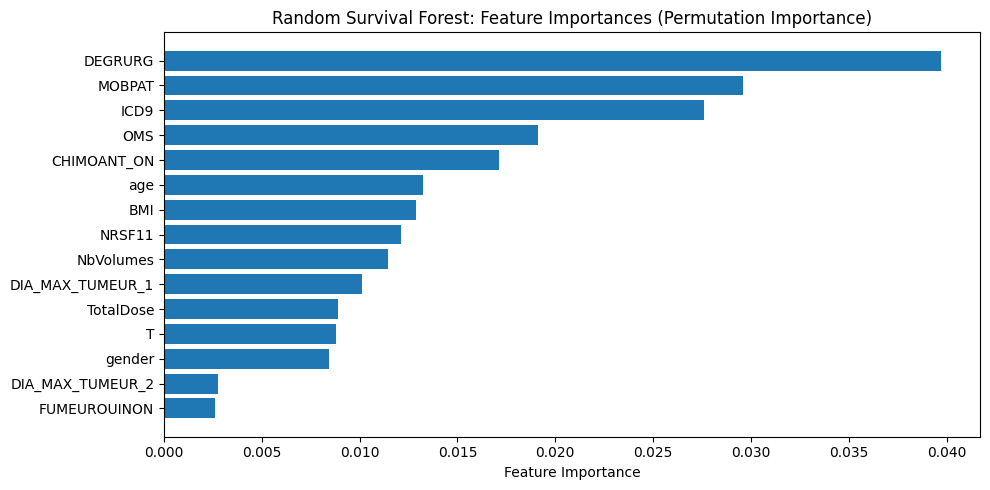

In [11]:
# --- Feature Importance using Permutation Importance ---
y_test = Surv.from_arrays(event_test, time_test)
perm_importance = permutation_importance(rsf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
importances = perm_importance.importances_mean
features = X.columns

# Sort features by importance
sorted_idx = importances.argsort()[::-1]
sorted_features = features[sorted_idx]
sorted_importances = importances[sorted_idx]

# Plot
plt.figure(figsize=(10, 5))
plt.barh(sorted_features, sorted_importances)
plt.xlabel("Feature Importance")
plt.title("Random Survival Forest: Feature Importances (Permutation Importance)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train['event'])
gbc_pred = gbc.predict(X_test)
gbm_auc = roc_auc_score(y_test['event'], gbc_pred)
print(f'Gradient Boosting Machine AUC: {gbm_auc:.4f}')

Gradient Boosting Machine AUC: 0.6099


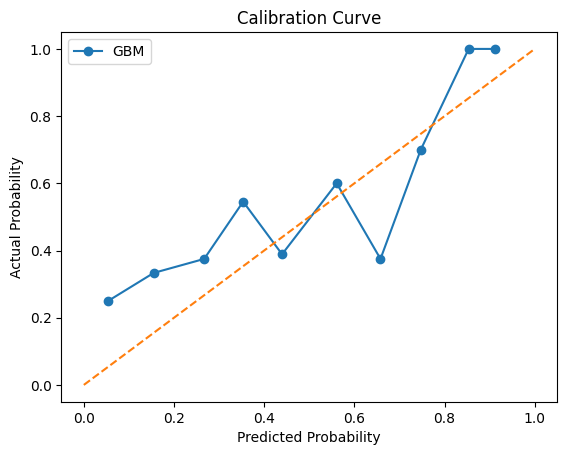

In [13]:
from sklearn.calibration import calibration_curve

# 16. Calibration Plot
probs = gbc.predict_proba(X_test)[:, 1]
true, pred = calibration_curve(y_test['event'], probs, n_bins=10)
plt.plot(pred, true, marker='o', label='GBM')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('Predicted Probability')
plt.ylabel('Actual Probability')
plt.title('Calibration Curve')
plt.legend()
plt.show()

In [14]:
# 10. Cross-Validation for Survival Models
y = Surv.from_arrays(df['dead'], df['time_in_months'])
kf = KFold(n_splits=5)
for train_idx, test_idx in kf.split(X):
    X_train_cv, X_test_cv = X.iloc[train_idx], X.iloc[test_idx]
    y_train_cv, y_test_cv = y[train_idx], y[test_idx]  # Use NumPy array indexing for y

    # Refit and evaluate the model on each fold
    rsf.fit(X_train_cv, y_train_cv)  # Pass y_train_cv directly
    rsf_pred_cv = rsf.predict(X_test_cv)
    auc_cv = roc_auc_score(y_test_cv['event'], rsf_pred_cv)
    print(f'Fold AUC: {auc_cv:.4f}')

Fold AUC: 0.6299
Fold AUC: 0.6360
Fold AUC: 0.7168
Fold AUC: 0.7877
Fold AUC: 0.7437


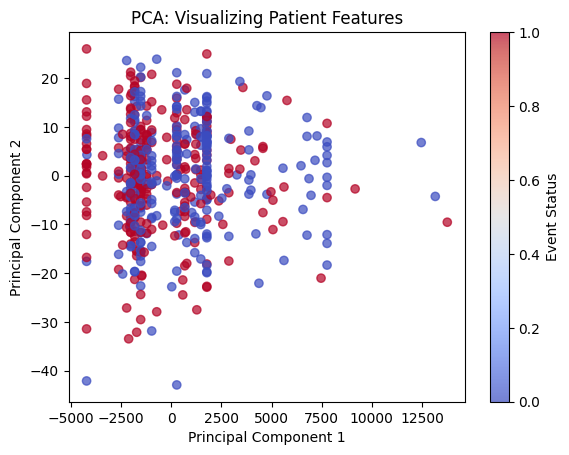

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_result = pca.fit_transform(df[['ICD9', 'OMS', 'TotalDose', 'age', 'BMI']])
df['PC1'], df['PC2'] = pca_result[:, 0], pca_result[:, 1]

plt.scatter(df['PC1'], df['PC2'], c=df['dead'], cmap='coolwarm', alpha=0.7)
plt.title('PCA: Visualizing Patient Features')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Event Status')
plt.show()

In [16]:
# 18. Feature Selection with Lasso
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X, y['event'])
coef = pd.Series(lasso.coef_, index=X.select_dtypes(include=[np.number]).columns)
print(coef)

age                 0.000000
BMI                -0.010453
DIA_MAX_TUMEUR_1    0.002624
DIA_MAX_TUMEUR_2    0.000000
TotalDose          -0.061685
NbVolumes           0.000000
gender             -0.000000
FUMEUROUINON        0.000000
ICD9                0.040551
DEGRURG            -0.113907
CHIMOANT_ON         0.075753
NRSF11              0.004891
OMS                 0.073643
MOBPAT             -0.000000
T                   0.002799
dtype: float64


In [17]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.metrics import concordance_index_ipcw

gbsa = GradientBoostingSurvivalAnalysis(
    n_estimators=100, 
    learning_rate=0.1, 
    max_depth=5,
    random_state=42
)
gbsa.fit(X_train, y_train)
c_index_gbsa = concordance_index_censored(event_test.astype(bool), time_test, gbsa.predict(X_test))
c_index_gbsa_ = concordance_index_ipcw(y_train, y_test, gbsa.predict(X_test))
print(f"Gradient Boosting Survival Analysis C-index: {c_index_gbsa[0]:.4f}")
print(f"Gradient Boosting Survival Analysis IPCW C-index: {c_index_gbsa_[0]:.4f}")

Gradient Boosting Survival Analysis C-index: 0.7077
Gradient Boosting Survival Analysis IPCW C-index: 0.6220


In [18]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import make_scorer

# 1. Створення функції оцінки C-індексу (score function)
def c_index_scorer(estimator, X, y_train, y_test):
    # 'estimator' - це навчена модель GBSA
    # 'y' - це структурований масив (Status, Time)
    
    # 1. Прогноз ризику
    risk_score = estimator.predict(X) 
    
    # 2. Обчислення C-індексу
    # Тут використовуємо IPCW C-індекс для коректної оцінки
    c_index = concordance_index_ipcw(y_train, y_test, risk_score)[0] # [0] повертає лише значення C-index
    
    return c_index 

# 2. Перетворення функції на об'єкт Scikit-learn Scorer (не є необхідним, але робить процес більш явним)
# scoring_metric = make_scorer(c_index_scorer, greater_is_better=True)
# В даному випадку GridSearchCV може прийняти функцію напряму, якщо вона слідує протоколу.

In [19]:
# 1. Ініціалізація моделі GBSA
gbsa_base = GradientBoostingSurvivalAnalysis(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200],  # Кількість бустингових ітерацій
    'learning_rate': [0.01, 0.05, 0.1, 0.2], # Швидкість навчання
    'max_depth': [3, 5, 7],         # Максимальна глибина дерев
}

# 2. Ініціалізація GridSearchCV
# cv=5 означає 5-кратну крос-валідацію
grid_search = GridSearchCV(
    estimator=gbsa_base,
    param_grid=param_grid,
    scoring=c_index_scorer,  # Використовуємо нашу функцію C-індексу
    cv=KFold(n_splits=5, shuffle=True, random_state=42), # Забезпечуємо випадкове перемішування
    n_jobs=-1,  # Використовуємо всі ядра процесора
    verbose=1
)

# 3. Запуск пошуку
# X_train - ознаки, y_train - структурований масив
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


d:\projects\chu_radiotherapy\env\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


,estimator,GradientBoost...ndom_state=42)
,param_grid,"{'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,<function c_i...00205B026A700>
,n_jobs,-1
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,loss,'coxph'


In [20]:
# Найкращий показник C-індексу, знайдений під час крос-валідації
best_score = grid_search.best_score_
print(f"Найкращий C-індекс (IPCW) крос-валідації: {best_score:.4f}")

# Найкраща комбінація гіперпараметрів
best_params = grid_search.best_params_
print(f"Найкращі параметри: {best_params}")

# Найкраща модель, готова до фінального тестування
best_gbsa_model = grid_search.best_estimator_

# Фінальна оцінка на тестовому наборі (y_test має бути структурованим)
final_c_index = c_index_scorer(best_gbsa_model, X_test, y_train, y_test)
print(f"Фінальний IPCW C-індекс на тестовому наборі: {final_c_index:.4f}")

Найкращий C-індекс (IPCW) крос-валідації: nan
Найкращі параметри: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 50}
Фінальний IPCW C-індекс на тестовому наборі: 0.6144


C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


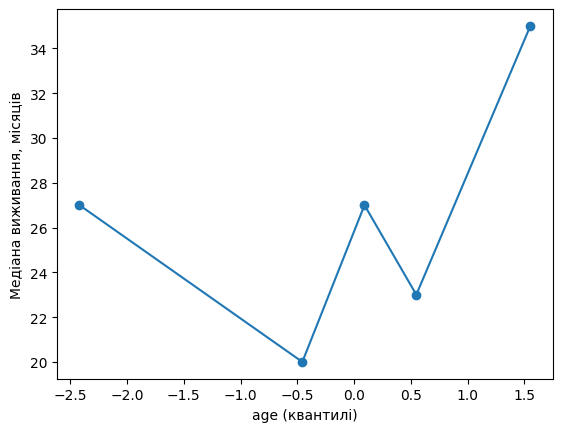

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


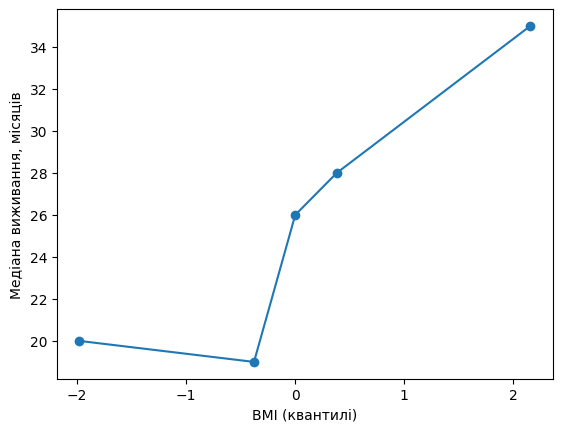

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


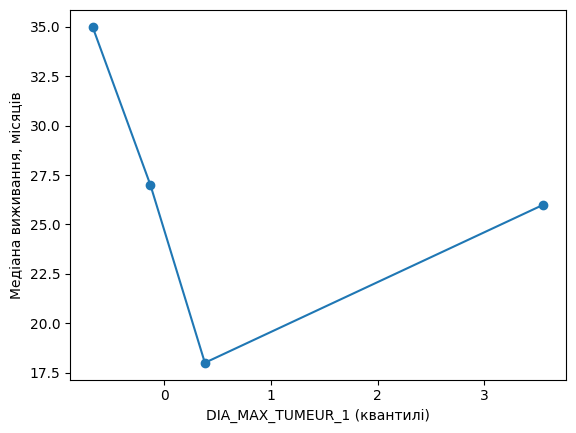

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


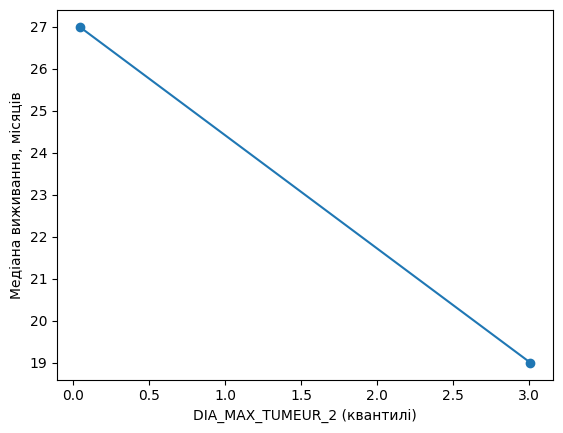

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


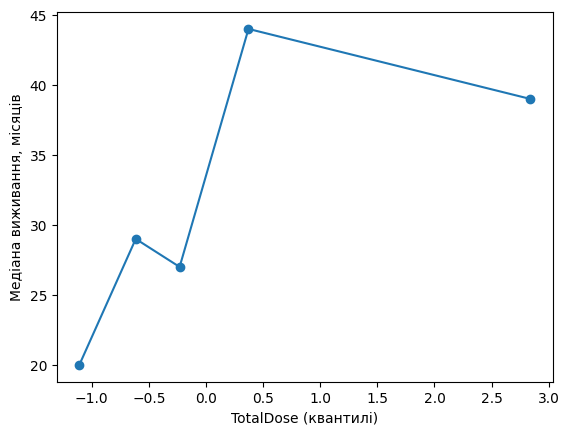

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


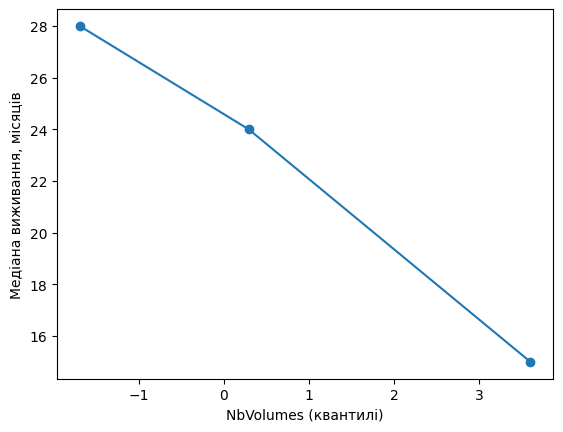

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


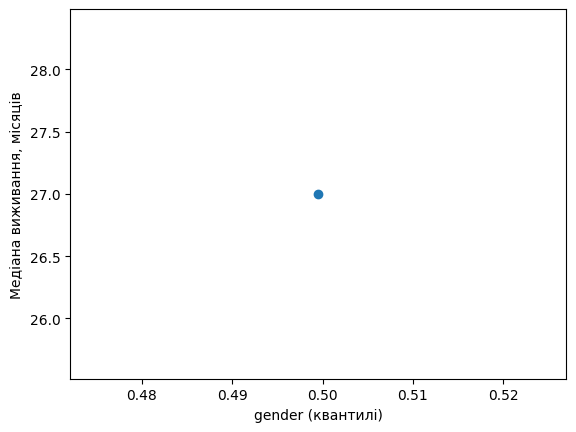

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


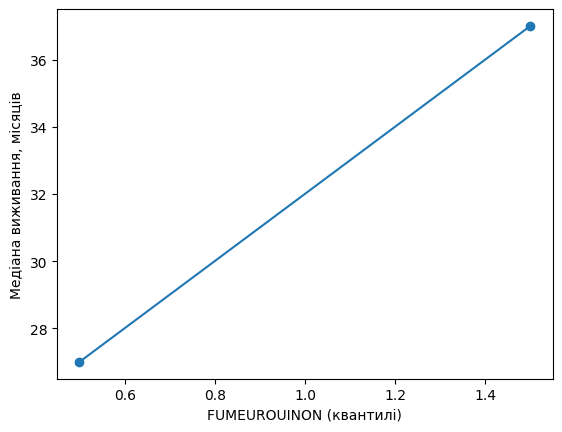

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


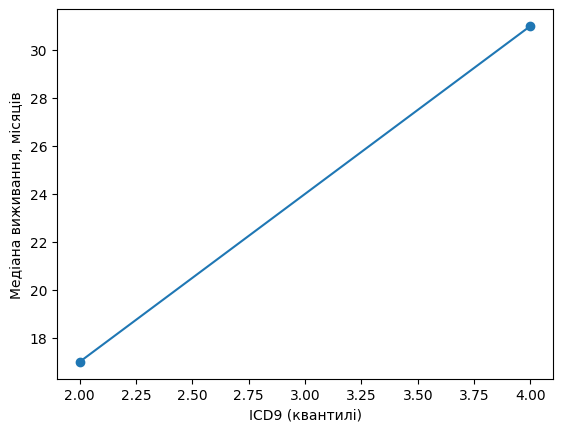

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


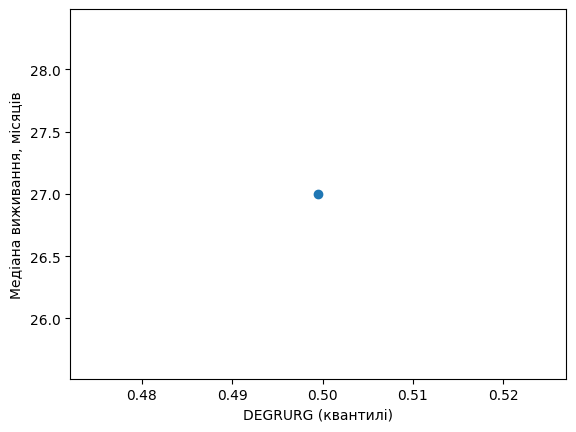

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


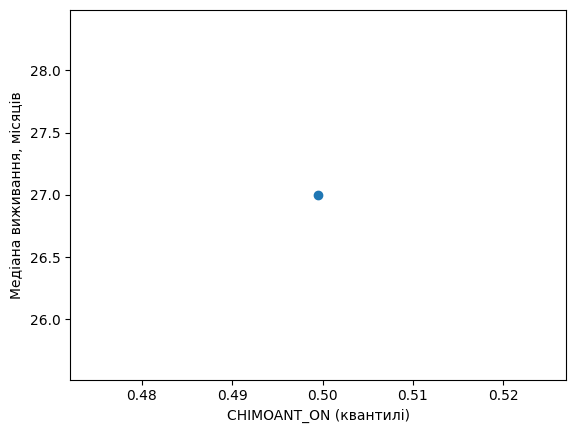

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


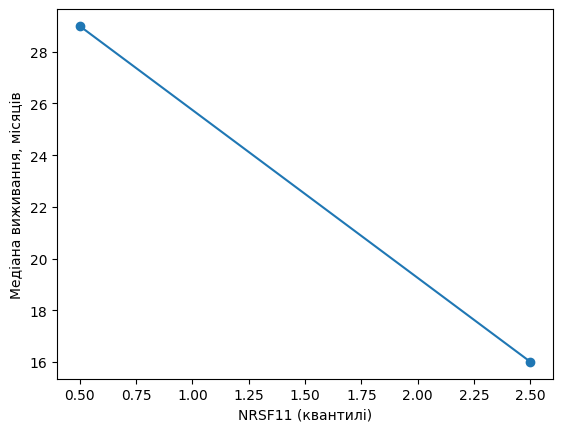

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


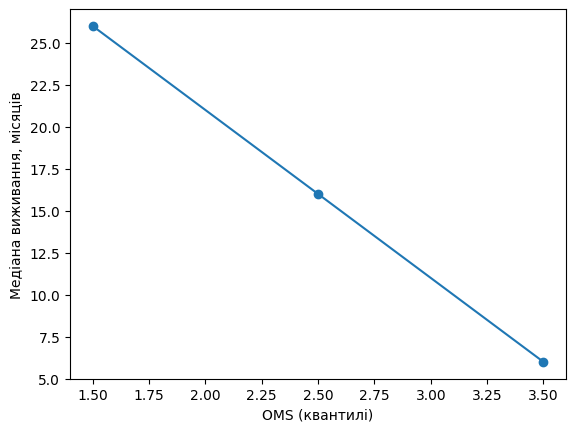

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


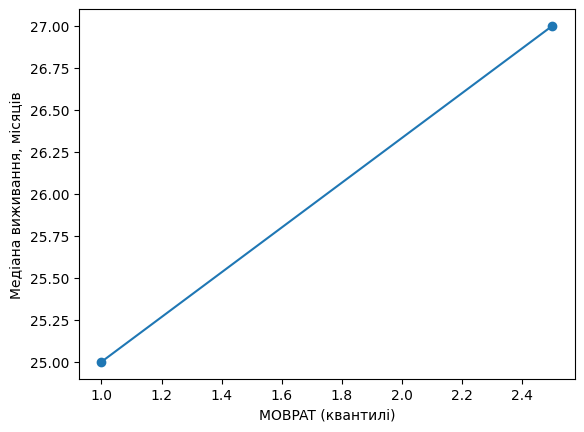

C:\Users\Olesia_Liashenko\AppData\Local\Temp\ipykernel_7284\2961291605.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for q, group in df_plot.groupby('var_quantile'):


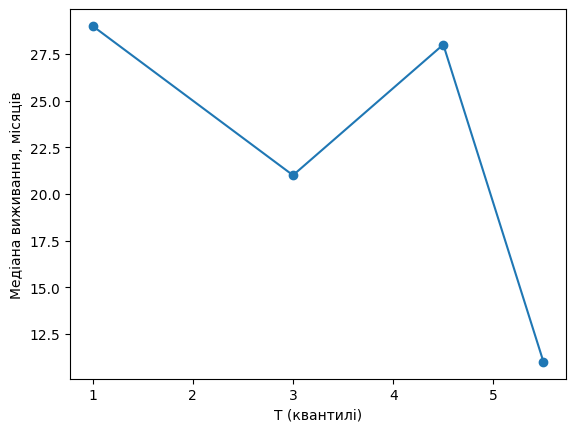

In [ ]:
# 1. Подивитися реальний зв’язок показника з виживанням (без моделі)
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
features = num_features + cat_features
def plot_surv_med(vars = features):
    for var in vars:
        df_plot = pd.DataFrame({var: X_train[var],
                                'time': time_train,
                                'event': event_train})

        # Квантилі показника
        df_plot['var_quantile'] = pd.qcut(df_plot[var], 5, duplicates='drop')

        survival_by_var = []
        for q, group in df_plot.groupby('var_quantile'):
            kmf = KaplanMeierFitter()
            kmf.fit(group['time'], group['event'])
            survival_by_var.append((q.mid, kmf.median_survival_time_))

        var_mid, median_surv = zip(*survival_by_var)
        plt.plot(var_mid, median_surv, 'o-')
        plt.xlabel(f'{var} (квантилі)')
        plt.ylabel('Медіана виживання, місяців')
        plt.show()
plot_surv_med()